In [1]:
import sys
sys.path.append("..")

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import SpectralEmbedding, TSNE, MDS
import torch
import umap
import hdbscan
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
import matplotlib as mpl




In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 4GB Laptop GPU


## Read data

In [3]:
time_step = 212
phi = 0.40
lat_size = 100
df = pd.read_csv(f"../isocontours/phi{phi:.2f}/h400x{lat_size}_ref/extracted_flame_front_{time_step}.csv")


## Pairplots

In [4]:
# sns.pairplot(df[features])
# plt.suptitle('Physical Space Pairplot', y=1.02)
# plt.show()

## UMAP

C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


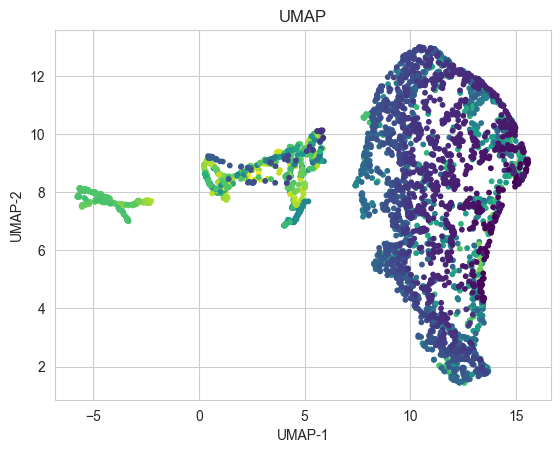

In [5]:
features = ['H2','O2', 'H2O', 'HO2', 'H2O2']
colourmap = df["u"]
X = StandardScaler().fit_transform(df[features])
# UMAP embedding
reducer = umap.UMAP(
    n_neighbors=100,
    n_components=2,
    random_state=42,
    init = 'spectral'
)
X_embedded = reducer.fit_transform(X)
# Plot
plt.scatter(X_embedded[:,0], X_embedded[:,1],c=colourmap, cmap='viridis', s=10)
plt.title("UMAP")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

## UMAP -> HDBSCAN -> MI -> Mapping to original space
Taken from "Identifying key features in reactive flows: A tutorial on combining
dimensionality reduction, unsupervised clustering, and feature correlation"

## HDBSCAN: Parameter Selection
- min_cluster_size: Smallest allowable grouping
- min_samples: the bigger the more points will be declared as noise

In [6]:
# ============================================================
# HDBSCAN CLUSTERING
# ============================================================

print(int(np.sqrt(len(X))))
clusterer = hdbscan.HDBSCAN(
    min_cluster_size= 15,#int(np.sqrt(len(X))),
    min_samples= 20,#int(np.sqrt(len(X))), #,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,
).fit(X_embedded)

labels = clusterer.labels_
proba  = clusterer.probabilities_
outlier_scores = clusterer.outlier_scores_

unique, counts = np.unique(labels, return_counts=True)
cluster_summary = dict(zip(unique, counts))
print("Cluster summary:", cluster_summary)
print("Number of clusters (excluding noise):", len(set(labels)) - (1 if -1 in labels else 0))
print("Noise fraction:", np.mean(labels == -1))
print("Average cluster probability:", proba[labels != -1].mean() if np.any(labels != -1) else 0)


59


C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Cluster summary: {np.int64(-1): np.int64(70), np.int64(0): np.int64(627), np.int64(1): np.int64(2628), np.int64(2): np.int64(61), np.int64(3): np.int64(69), np.int64(4): np.int64(24), np.int64(5): np.int64(20)}
Number of clusters (excluding noise): 6
Noise fraction: 0.020005715918833954
Average cluster probability: 0.9709883360641604


In [7]:

# ============================================================
# GLOBAL MUTUAL INFORMATION
# ============================================================
from sklearn.feature_selection import mutual_info_regression

mi_x1 = mutual_info_regression(X, X_embedded[:, 0], random_state=0)
mi_x2 = mutual_info_regression(X, X_embedded[:, 1], random_state=0)

df_mi_global = pd.DataFrame({
    'feature': features,
    'MI_dim1': mi_x1,
    'MI_dim2': mi_x2,
    'MI_sum':  mi_x1 + mi_x2
}).sort_values('MI_sum', ascending=False)

print("Global mutual information ranking:")
print(df_mi_global.head(10))
# ============================================================
# PER-CLUSTER MUTUAL INFORMATION
# ============================================================
cluster_labels = sorted(set(labels) - {-1})
mi_cluster = {}

for cluster in cluster_labels:
    mask = labels == cluster
    if mask.sum() < 10:
        continue

    mi1 = mutual_info_regression(X[mask], X_embedded[mask, 0], random_state=0)
    mi2 = mutual_info_regression(X[mask], X_embedded[mask, 1], random_state=0)

    df_new = pd.DataFrame({
        'feature': features,
        'MI_dim1': mi1,
        'MI_dim2': mi2,
        'MI_sum':  mi1 + mi2
    }).sort_values('MI_sum', ascending=False)

    mi_cluster[cluster] = df_new


# Plot top correlations
# for cluster, df_new in mi_cluster.items():
#     top = df_new.head(5)
#     plt.figure(figsize=(5,3))
#     plt.barh(top['feature'][::-1], top['MI_sum'][::-1])
#     plt.xlabel("Mutual Information (sum over dims)")
#     plt.title(f"Cluster {cluster} — Top correlated features")
#     plt.tight_layout()
#     plt.show()



Global mutual information ranking:
  feature   MI_dim1   MI_dim2    MI_sum
0      H2  1.845366  0.911216  2.756582
4    H2O2  1.099072  1.600703  2.699775
3     HO2  1.679628  0.889669  2.569297
1      O2  1.386930  0.805134  2.192064
2     H2O  1.306172  0.783040  2.089212


               H2        O2       H2O       HO2      H2O2
cluster                                                  
-1       0.000107  0.176199  0.068520  0.000023  0.000012
 0       0.001259  0.172717  0.069903  0.000093  0.000011
 1       0.001956  0.170964  0.071339  0.000112  0.000011
 2       0.000195  0.176022  0.068731  0.000034  0.000014
 3       0.000073  0.176231  0.068954  0.000018  0.000012


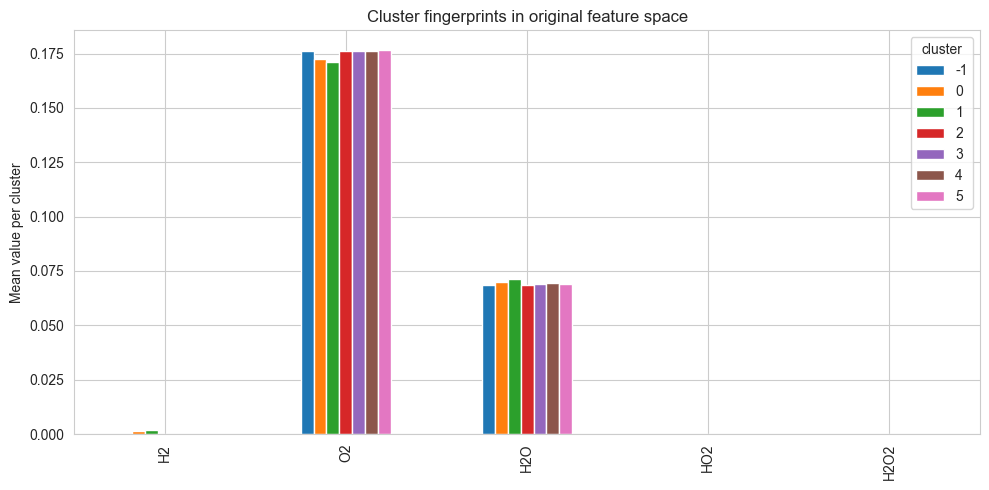

In [8]:
# ============================================================
# STATISTICS + FINGERPRINTS
# ============================================================
df_with_labels = df.copy()
df_with_labels["cluster"] = labels

cluster_means = df_with_labels.groupby("cluster")[features].mean()
cluster_stds  = df_with_labels.groupby("cluster")[features].std()

print(cluster_means.head())

cluster_means.T.plot(kind='bar', figsize=(10,5))
plt.ylabel("Mean value per cluster")
plt.title("Cluster fingerprints in original feature space")
plt.tight_layout()
plt.show()


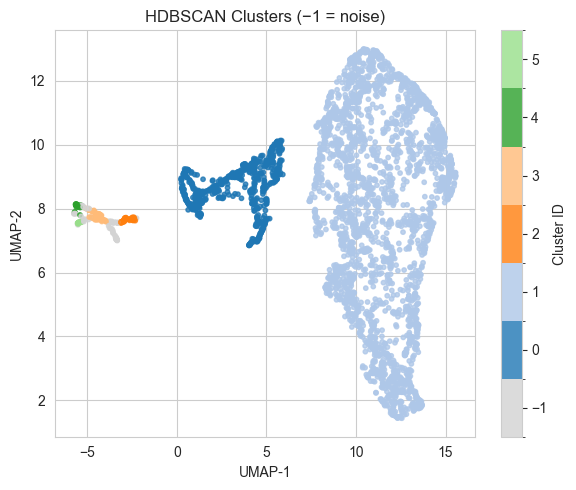

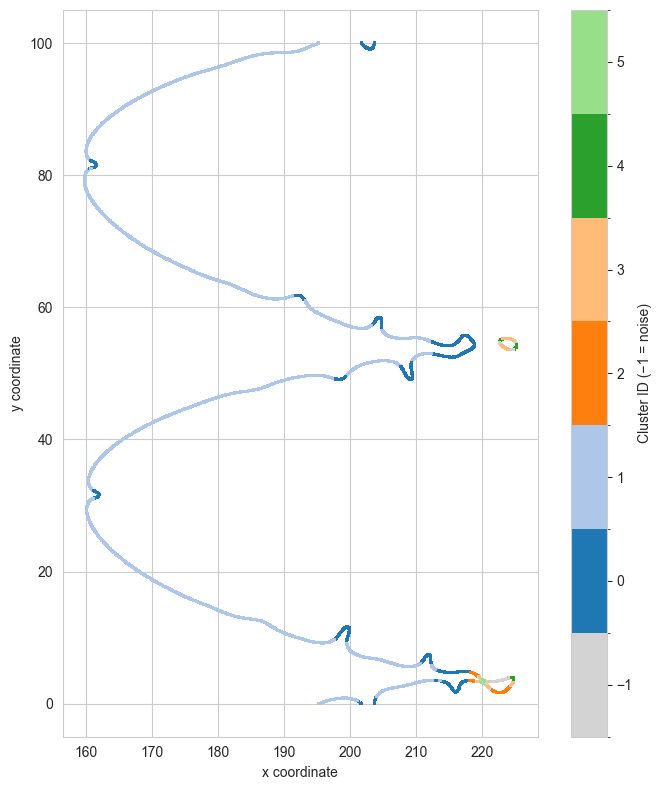

In [9]:

# ============================================================
# COMMON COLORMAP + NORM FOR ALL PLOTS
# ============================================================
labels_unique = np.unique(labels)

# Number of real clusters (ignore noise = -1)
n_clusters = np.sum(labels_unique >= 0)

# Base colormap for clusters
base_cmap = mpl.colormaps['tab20']  # or any other you like

# Build a ListedColormap so we can control noise color
colors = ['lightgrey']  # color for noise (-1)
colors += [base_cmap(i) for i in range(n_clusters)]
cmap = mpl.colors.ListedColormap(colors)

# Bounds: from -1.5, -0.5, 0.5, ..., (n_clusters - 0.5)
bounds = np.arange(-1.5, n_clusters + 0.5, 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# ============================================================
# 1) UMAP SPACE PLOT (USE SAME cmap & norm)
# ============================================================
plt.figure(figsize=(6, 5))
sc1 = plt.scatter(
    X_embedded[:, 0], X_embedded[:, 1],
    c=labels,
    cmap=cmap,
    norm=norm,
    s=10,
    alpha=0.8
)
plt.title("HDBSCAN Clusters (−1 = noise)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
cb1 = plt.colorbar(sc1, ticks=np.arange(-1, n_clusters))
cb1.set_label("Cluster ID")
plt.tight_layout()
plt.show()

# ============================================================
# 2) PHYSICAL (x, y) SPACE PLOT (REUSE cmap & norm)
# ============================================================
plt.figure(figsize=(7, 8))
sc2 = plt.scatter(
    df['x'],
    df['y'],
    c=labels,
    cmap=cmap,
    norm=norm,
    s=5,
    marker='s',
    linewidths=0
)
cb2 = plt.colorbar(sc2, ticks=np.arange(-1, n_clusters))
cb2.set_label("Cluster ID (−1 = noise)")

plt.xlabel("x coordinate")
plt.ylabel("y coordinate")
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

## UMAP + HDBSCAN: Comparison MF vs Reaction reates

C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all

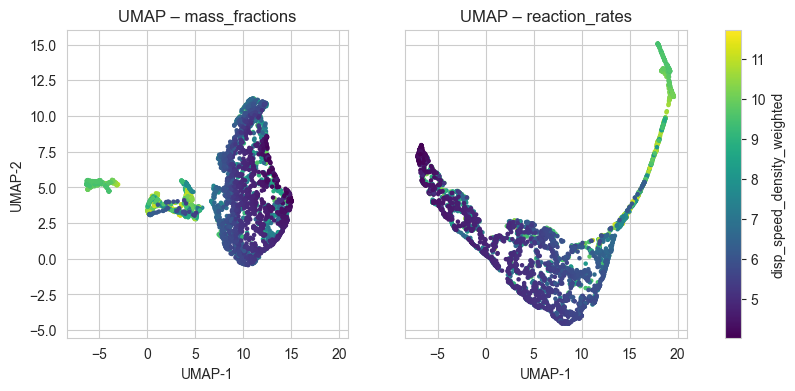

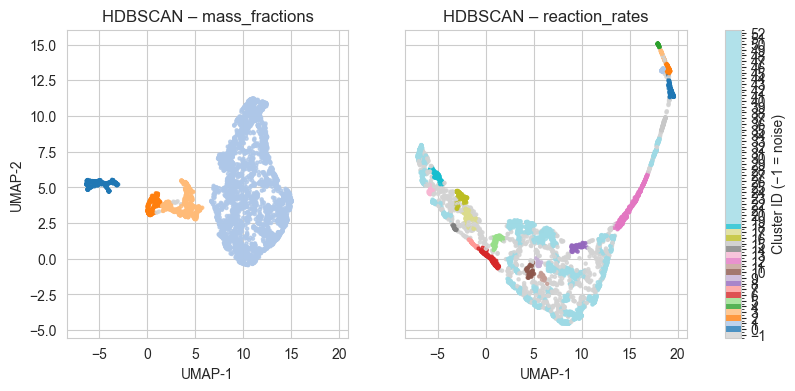

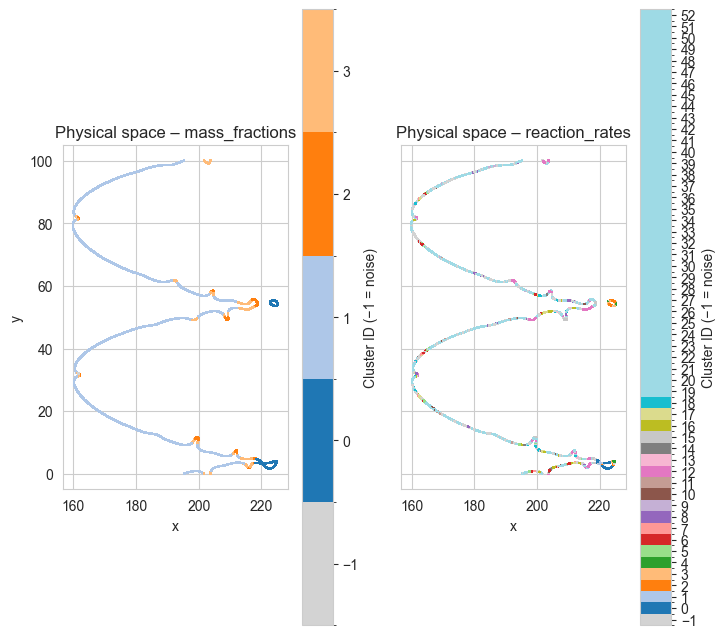

In [10]:
# Two alternative feature sets
feature_sets = {
    "mass_fractions": ['H2', 'O2', 'H2O', 'HO2', 'H2O2'],
    "reaction_rates": ['omega_H2', 'omega_O2', 'omega_H2O','omega_H2O2']
}

# Common models
scaler = StandardScaler()
reducer = umap.UMAP(
    n_neighbors=100,
    n_components=2,
    random_state=42,
    init='pca'
)

results = {}

# ----------------------------------------------------
# Run: scaling -> UMAP -> HDBSCAN -> global MI
# ----------------------------------------------------
for name, feats in feature_sets.items():
    X = scaler.fit_transform(df[feats])
    X_emb = reducer.fit_transform(X)

    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=15,
        min_samples=15,
        metric='euclidean',
        cluster_selection_method='eom',
        prediction_data=True,
    ).fit(X_emb)

    labels = clusterer.labels_

    mi_x1 = mutual_info_regression(X, X_emb[:, 0], random_state=0)
    mi_x2 = mutual_info_regression(X, X_emb[:, 1], random_state=0)
    df_mi = pd.DataFrame({
        "feature": feats,
        "MI_dim1": mi_x1,
        "MI_dim2": mi_x2,
        "MI_sum":  mi_x1 + mi_x2
    }).sort_values("MI_sum", ascending=False)

    results[name] = {
        "features": feats,
        "X_emb": X_emb,
        "labels": labels,
        "mi_global": df_mi,
    }

    # print(f"\n=== {name} ===")
    # unique, counts = np.unique(labels, return_counts=True)
    # n_clusters = len(set(labels) - {-1})
    # print("Cluster summary:", dict(zip(unique, counts)))
    # print("Number of clusters (excluding noise):", n_clusters)
    # print("Noise fraction:", np.mean(labels == -1))
    # print("Top global MI features:")
    # print(df_mi.head(5))

# ----------------------------------------------------
# Side-by-side UMAP embeddings (colored by Sd)
# ----------------------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for ax, (name, res) in zip(axs, results.items()):
    sc = ax.scatter(
        res["X_emb"][:, 0],
        res["X_emb"][:, 1],
        c=colourmap,
        cmap="viridis",
        s=5
    )
    ax.set_title(f"UMAP – {name}")
    ax.set_xlabel("UMAP-1")
axs[0].set_ylabel("UMAP-2")
fig.colorbar(sc, ax=axs, label="disp_speed_density_weighted")
plt.show()

# ----------------------------------------------------
# Side-by-side UMAP embeddings (colored by cluster ID)
# ----------------------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

for ax, (name, res) in zip(axs, results.items()):
    labels = res["labels"]
    labs_unique = np.unique(labels)
    n_clusters = np.sum(labs_unique >= 0)

    base_cmap = mpl.colormaps['tab20']
    colors = ['lightgrey'] + [base_cmap(i) for i in range(n_clusters)]
    cmap = mpl.colors.ListedColormap(colors)
    bounds = np.arange(-1.5, n_clusters + 0.5, 1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    sc = ax.scatter(
        res["X_emb"][:, 0],
        res["X_emb"][:, 1],
        c=labels,
        cmap=cmap,
        norm=norm,
        s=5,
        alpha=0.8,
    )
    ax.set_title(f"HDBSCAN – {name}")
    ax.set_xlabel("UMAP-1")
axs[0].set_ylabel("UMAP-2")
cb = fig.colorbar(sc, ax=axs, ticks=np.arange(-1, n_clusters))
cb.set_label("Cluster ID (−1 = noise)")
plt.show()

# ----------------------------------------------------
# Physical (x, y) space side-by-side (colored by cluster ID)
# ----------------------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(8, 8), sharex=True, sharey=True)
for ax, (name, res) in zip(axs, results.items()):
    labels = res["labels"]
    labs_unique = np.unique(labels)
    n_clusters = np.sum(labs_unique >= 0)

    base_cmap = mpl.colormaps['tab20']
    colors = ['lightgrey'] + [base_cmap(i) for i in range(n_clusters)]
    cmap = mpl.colors.ListedColormap(colors)
    bounds = np.arange(-1.5, n_clusters + 0.5, 1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    sc = ax.scatter(
        df["x"], df["y"],
        c=labels,
        cmap=cmap,
        norm=norm,
        s=3,
        marker='s',
        linewidths=0
    )
    ax.set_title(f"Physical space – {name}")
    ax.set_xlabel("x")
    ax.set_aspect('equal', adjustable='box')

    cb = plt.colorbar(sc, ax=ax, ticks=np.arange(-1, n_clusters))
    cb.set_label("Cluster ID (−1 = noise)")

axs[0].set_ylabel("y")
plt.show()


## PCA: Chemichal State vs Reaction rates

[State-space features (φ)] Centroids in original feature units:
 [[1.86192958e-03 1.71188605e-01 7.12220740e-02 3.67457559e-05
  4.35113955e-04 3.68156969e-04 1.09973720e-04 1.04791805e-05]
 [3.87820071e-04 1.75443647e-01 6.87068293e-02 2.98525826e-06
  8.47569095e-05 9.44898878e-05 4.91784052e-05 1.34135196e-05]
 [1.42569941e-04 1.76374245e-01 6.91804527e-02 7.95204985e-07
  3.06127238e-05 4.55629341e-05 2.60942214e-05 1.09735499e-05]
 [2.27292176e-03 1.70277261e-01 7.13156049e-02 5.48543991e-05
  5.58945690e-04 4.66265421e-04 1.18023955e-04 1.03877071e-05]
 [1.85655266e-03 1.71000365e-01 7.13225207e-02 3.69660362e-05
  4.55112649e-04 3.93076967e-04 1.11614510e-04 1.18353114e-05]
 [1.13888307e-03 1.73087758e-01 6.98455386e-02 1.73809939e-05
  2.84789524e-04 2.60981897e-04 9.16366048e-05 1.15731437e-05]]

[State-space features (φ)] Feature contributions to first two PCs:
           PC1       PC2
H2    0.147910  0.000631
O     0.145552  0.009370
OH    0.143511  0.020390
O2    0.138535  

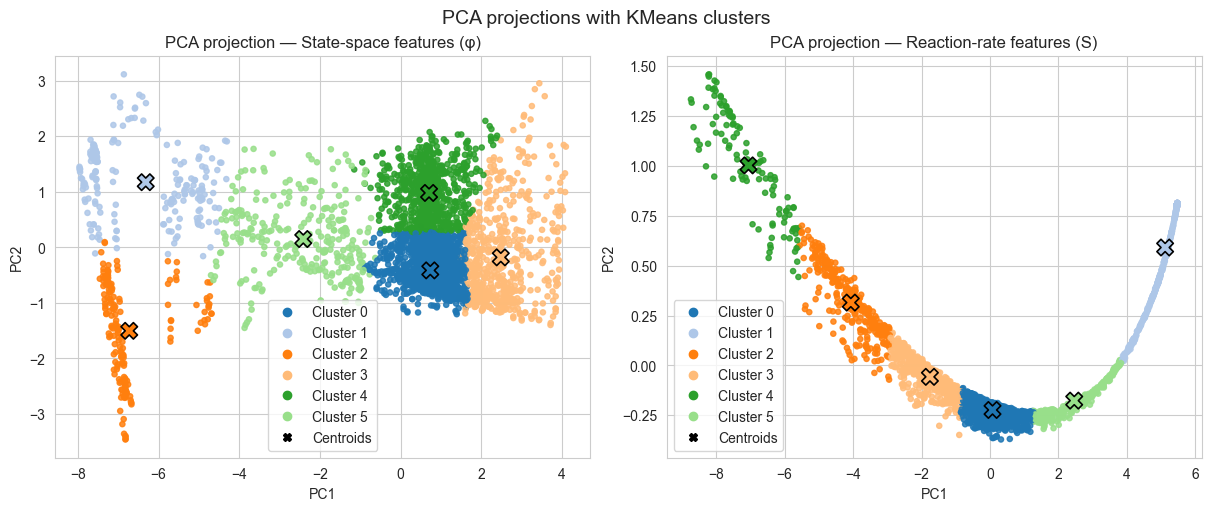

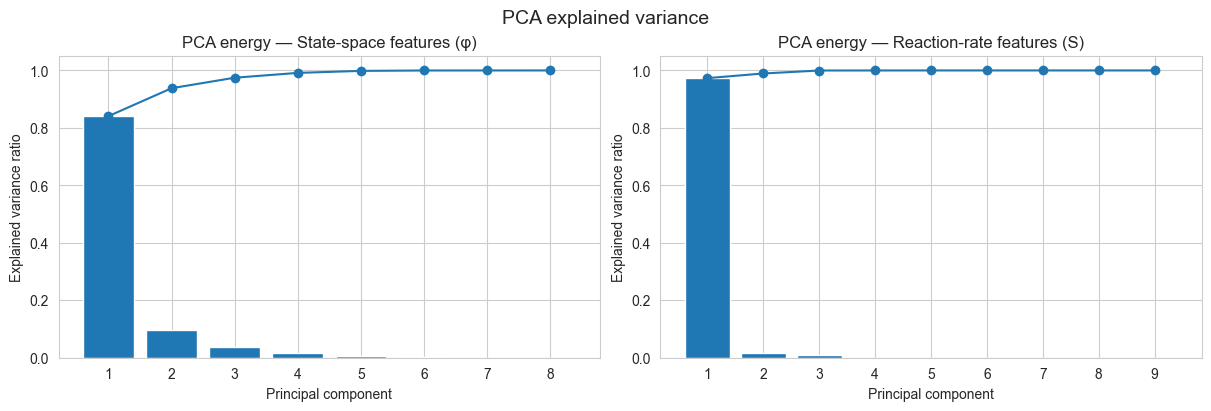

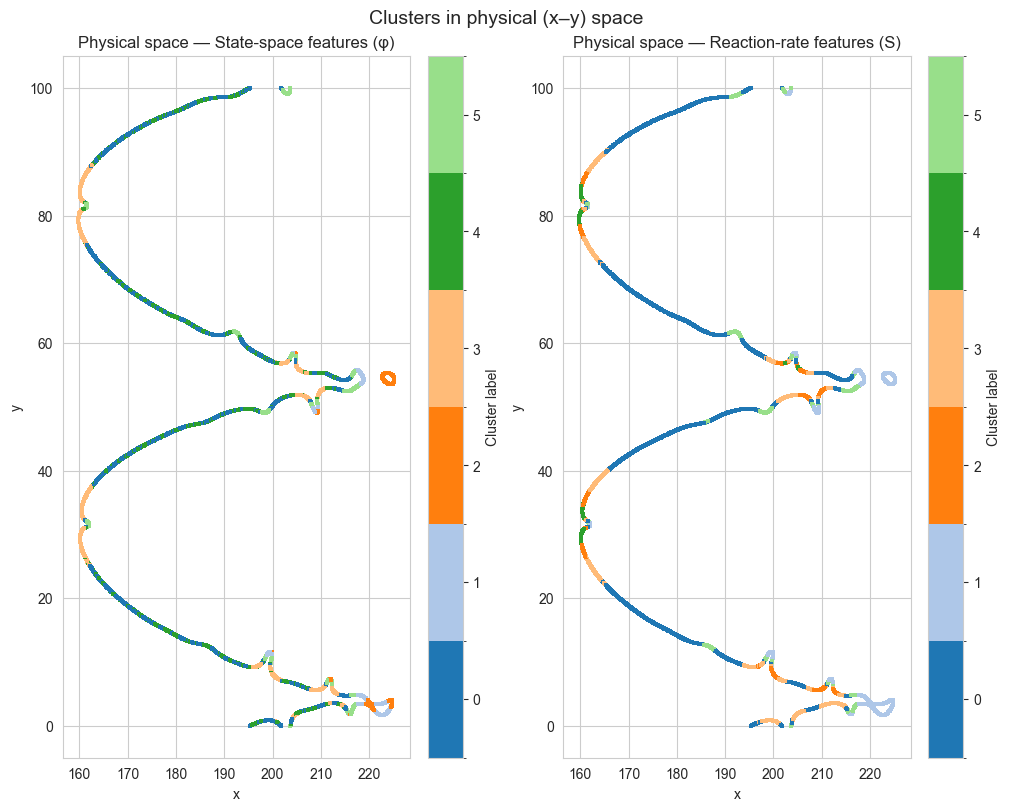

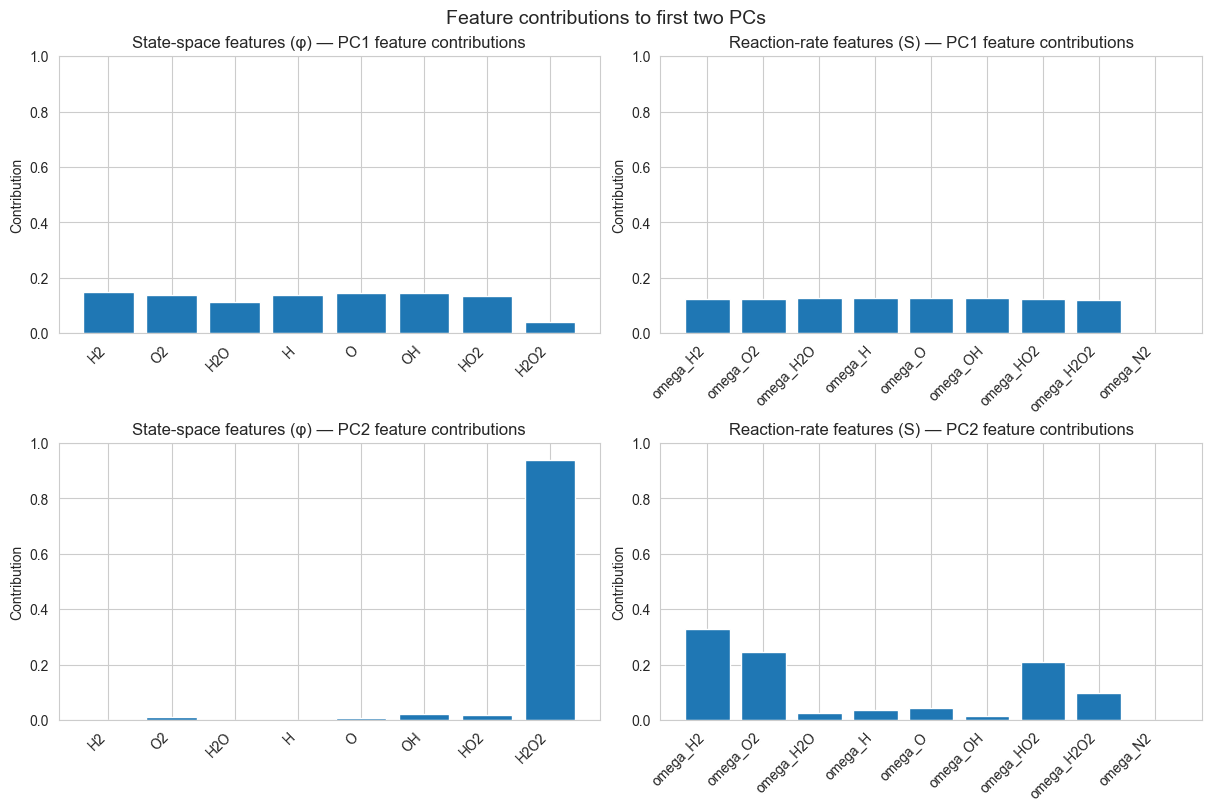

In [96]:
# --- Pre-create side-by-side figures (left=state features, right=rate features) ---
fig_pca,   axs_pca   = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
fig_scree, axs_scree = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
fig_phys,  axs_phys  = plt.subplots(1, 2, figsize=(10, 8), constrained_layout=True)

col_titles = {
    0: "State-space features (φ)",
    1: "Reaction-rate features (S)"
}

# Number of clusters (same for both feature settings)
k = 6

# ----- GLOBAL colormap + norm, reused everywhere -----
base_cmap = mpl.colormaps['tab20']          # choose any base cmap you like
colors = [base_cmap(i) for i in range(k)]   # take first k colors
cmap_clusters = ListedColormap(colors)

bounds = np.arange(-0.5, k + 0.5, 1)       # one band per integer label
norm_clusters = BoundaryNorm(bounds, cmap_clusters.N)

# Figure for feature contributions
fig_load, axs_load = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

# ==================================================================
# LOOP OVER FEATURE SETTINGS
# ==================================================================
for feature_setting in range(2):

    if feature_setting == 0:
        features = [
            'H2', 'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2'
        ]
    else:
        features = [
            'omega_H2', 'omega_O2', 'omega_H2O', 'omega_H', 'omega_O', 'omega_OH',
            'omega_HO2', 'omega_H2O2', 'omega_N2'
        ]

    # ------------------------------------------------------------------
    # KMeans on standardized features
    # ------------------------------------------------------------------
    X_raw = df[features].to_numpy()

    pipe = make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        KMeans(n_clusters=k, init="k-means++", n_init="auto",
               max_iter=300, random_state=0)
    )
    labels = pipe.fit_predict(X_raw)

    # Extract scaler and centroids
    scaler = pipe.named_steps["standardscaler"]
    centroids_scaled   = pipe.named_steps["kmeans"].cluster_centers_
    centroids_unscaled = scaler.inverse_transform(centroids_scaled)

    print(f"[{col_titles[feature_setting]}] Centroids in original feature units:\n",
          centroids_unscaled)

    X_scaled = scaler.transform(X_raw)

    # ------------------------------------------------------------------
    # PCA on scaled data (same space that KMeans sees)
    # ------------------------------------------------------------------
    pca = PCA(n_components=None, random_state=0)
    X2d         = pca.fit_transform(X_scaled)        # (n, >=2)
    centroids2d = pca.transform(centroids_scaled)    # centroids in PCA space

    # Feature contributions (squared loadings, normalized per PC)
    loadings = pca.components_[:2, :]                # first two PCs
    contrib = loadings**2
    contrib = contrib / contrib.sum(axis=1, keepdims=True)

    contrib_df = pd.DataFrame(
        contrib,
        index=["PC1", "PC2"],
        columns=features
    )

    print(f"\n[{col_titles[feature_setting]}] Feature contributions to first two PCs:")
    print(contrib_df.T.sort_values("PC1", ascending=False))

    # ------------------------------------------------------------------
    # Bar plots: feature contributions (PC1 & PC2)
    # ------------------------------------------------------------------
    for pc_idx, pc_name in enumerate(["PC1", "PC2"]):
        ax_l = axs_load[pc_idx, feature_setting]
        ax_l.bar(np.arange(len(features)), contrib[pc_idx])
        ax_l.set_xticks(np.arange(len(features)))
        ax_l.set_xticklabels(features, rotation=45, ha="right")
        ax_l.set_ylabel("Contribution")
        ax_l.set_ylim(0, 1)
        ax_l.set_title(f"{col_titles[feature_setting]} — {pc_name} feature contributions")

    # ------------------------------------------------------------------
    # Explained variance
    # ------------------------------------------------------------------
    evr     = pca.explained_variance_ratio_
    cum_evr = np.cumsum(evr)

    print(f"\n[{col_titles[feature_setting]}] Explained variance ratio per component:")
    for i, (e, c) in enumerate(zip(evr, cum_evr), start=1):
        print(f"  PC{i:>2}: {e:7.4f}   (cumulative: {c:7.4f})")

    # ------------------------------------------------------------------
    # Plot A: PCA clusters (same colors as physical map)
    # ------------------------------------------------------------------
    axp = axs_pca[feature_setting]

    # Points
    sc_pca = axp.scatter(
        X2d[:, 0], X2d[:, 1],
        c=labels,
        cmap=cmap_clusters,
        norm=norm_clusters,
        s=14,
        alpha=0.85
    )

    # Centroids – colored by cluster index
    axp.scatter(
        centroids2d[:, 0], centroids2d[:, 1],
        c=np.arange(k),
        cmap=cmap_clusters,
        norm=norm_clusters,
        s=140,
        marker="X",
        edgecolor="k",
        linewidths=1.2
    )

    axp.set_title(f"PCA projection — {col_titles[feature_setting]}")
    axp.set_xlabel("PC1")
    axp.set_ylabel("PC2")

    # Optional legend with fixed cluster colors
    handles = [
        mpl.lines.Line2D([], [], linestyle="", marker="o",
                         color=cmap_clusters(i), label=f"Cluster {i}")
        for i in range(k)
    ]
    handles.append(
        mpl.lines.Line2D([], [], linestyle="", marker="X",
                         color="k", label="Centroids")
    )
    axp.legend(handles=handles, loc="best")

    # ------------------------------------------------------------------
    # Plot B: Scree (explained variance)
    # ------------------------------------------------------------------
    axs = axs_scree[feature_setting]
    idx = np.arange(1, len(evr) + 1)
    axs.bar(idx, evr)
    axs.plot(idx, cum_evr, marker="o")
    axs.set_title(f"PCA energy — {col_titles[feature_setting]}")
    axs.set_xlabel("Principal component")
    axs.set_ylabel("Explained variance ratio")
    axs.set_xticks(idx)

    # ------------------------------------------------------------------
    # Plot C: Physical x–y map (same colors as PCA)
    # ------------------------------------------------------------------
    ax_phys = axs_phys[feature_setting]

    sc_phys = ax_phys.scatter(
        df['x'],
        df['y'],
        c=labels,
        cmap=cmap_clusters,
        norm=norm_clusters,
        s=8,
        marker='s',
        linewidths=0
    )

    cb = fig_phys.colorbar(sc_phys, ax=ax_phys, ticks=np.arange(k))
    cb.set_label("Cluster label")

    ax_phys.set_xlabel("x")
    ax_phys.set_ylabel("y")
    ax_phys.set_title(f"Physical space — {col_titles[feature_setting]}")
    # ax_phys.set_aspect("equal")  # uncomment if you want equal aspect


# ------------------------------------------------------------------
# Final rendering
# ------------------------------------------------------------------
fig_pca.suptitle("PCA projections with KMeans clusters", fontsize=14)
fig_scree.suptitle("PCA explained variance", fontsize=14)
fig_phys.suptitle("Clusters in physical (x–y) space", fontsize=14)
fig_load.suptitle("Feature contributions to first two PCs", fontsize=14)

plt.show()



## Spectral Embedding

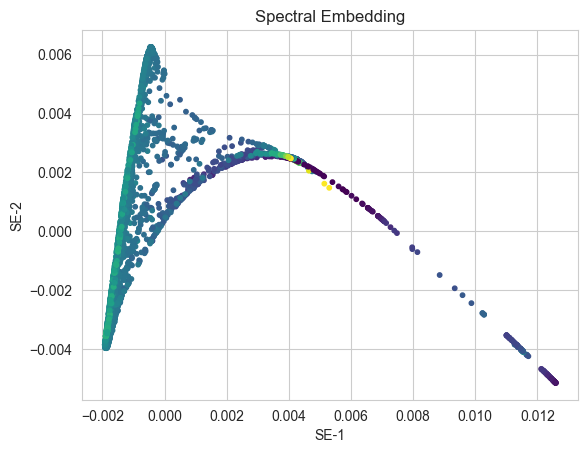

In [86]:
SE = SpectralEmbedding(n_components=2, n_neighbors=30)
X_SE = SE.fit_transform(X)
# Plot
plt.scatter(X_SE[:, 0], X_SE[:, 1], c=colourmap, cmap='viridis', s=10)
plt.title("Spectral Embedding")
plt.xlabel("SE-1")
plt.ylabel("SE-2")
plt.show()

## t-SNE

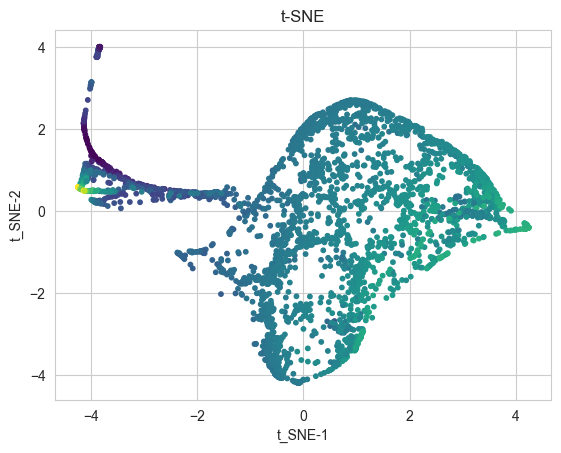

In [87]:
t_sne = TSNE(
    n_components=2,
    perplexity=30,
    init="random",
    max_iter=250,
    random_state=0,
)
X_sne = t_sne.fit_transform(X)

plt.scatter(X_sne[:,0], X_sne[:,1],c=colourmap, cmap='viridis', s=10)
plt.title("t-SNE")
plt.xlabel("t_SNE-1")
plt.ylabel("t_SNE-2")
plt.show()

## Mutidimensional Scaling

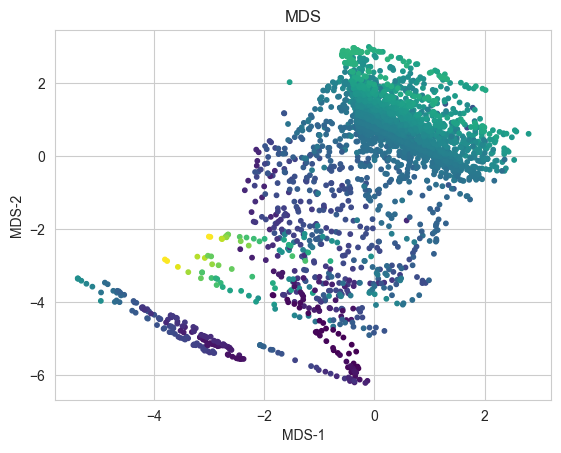

In [88]:
mds_embedding = MDS(n_components=2, n_init=1)
X_mds = mds_embedding.fit_transform(X)

plt.scatter(X_mds[:,0], X_mds[:,1],c=colourmap, cmap='viridis', s=10)
plt.title("MDS")
plt.xlabel("MDS-1")
plt.ylabel("MDS-2")
plt.show()